# Imports and loading data

In [302]:
import  numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from pandas_profiling import ProfileReport
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

train_data = pd.read_csv("C:\\Users\\Yousef\\Desktop\\Internship-Task\\training.csv")
test_data = pd.read_csv("C:\\Users\\Yousef\\Desktop\\Internship-Task\\validation.csv")
train_data.describe()

,variable2,variable3,variable8,variable11,variable14,variable15,variable17,variable19
count,3661.000000,3700.000000,3700.000000,3700.000000,3600.000000,3700.000000,3.600000e+03,3700.000000
mean,2698.231631,1210.569655,720.540000,4.160000,162.695000,2246.705946,1.626950e+06,0.925405
std,1690.388911,3163.834623,1930.736215,6.750553,156.045682,8708.571126,1.560457e+06,0.262772
min,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,1917.000000,0.000830,8.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000
50%,2558.000000,55.000000,71.000000,2.000000,120.000000,113.000000,1.200000e+06,1.000000
75%,3667.000000,452.250000,415.000000,6.000000,280.000000,1059.750000,2.800000e+06,1.000000
max,8025.000000,26335.000000,14415.000000,67.000000,1160.000000,100000.000000,1.160000e+07,1.000000


# Checking Target value imbalance 
- Majority class represents 93% , minority class represents 7%

In [303]:
#Check target value imbalance
train_data ['classLabel']=[1 if i == "yes." else 0 for i in train_data.classLabel]
print("Training data target value distrbution\n")
print(train_data['classLabel'].value_counts())
test_data['classLabel']=[1 if i == "yes." else 0 for i in test_data.classLabel]
# yes. represent 93% , no. represent only 7% percent of the data, there is a class imbalance.

Training data target value distrbution

1    3424
0     276
Name: classLabel, dtype: int64


# Exploring Data using pandas_profiling


In [304]:
#Exploring Data using pandas_profiling to get insights about the data.

wide_bot_profile = ProfileReport(train_data, title='WideBot Profiling Report', explorative = True)
wide_bot_profile
wide_bot_profile.to_file("WideBot.html")

C:\Users\Yousef\AppData\Roaming\Python\Python36\site-packages\pandas_profiling\visualisation\plot.py:154: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)


# HIGH CORRELATION
- There are highly correlated columns , which could affect the model performance because it's not adding new features or value to the model performance, So i dropped highly correlated columns for training and validation data


In [305]:
#vars:17,19,4,18 have high correlation which could affect the model.
train_data =train_data.drop(['variable17','variable19','variable4','variable18'],axis=1)
test_data =test_data.drop(['variable17','variable19','variable4','variable18'],axis=1) 


# MISSING VALUES
- Replacing missing categorical values by the most frequent value representing that class , replacing missing numerical values by the median representing that class. I didn't use the mean of the column because the mean could be affected by outliers values.

In [306]:
def fill_missing_values(data):
    data['variable1'].fillna('b',inplace=True)
    var2_median = data['variable2'].median()
    data['variable2'].fillna(var2_median,inplace=True)
    data['variable5'].fillna('g',inplace=True)
    data['variable6'].fillna('c',inplace=True)
    data['variable7'].fillna('v',inplace=True)
    var14_median = data['variable14'].median()
    data['variable14'].fillna(var14_median,inplace=True)
fill_missing_values(train_data)
fill_missing_values(test_data)

# ENCODING CATEGORICAL VALUES TO NUMERICAL VALUES.
- I used simple label encoder because it's faster approch and works well with tree based models and doesn't consume as much memory as onehot encoder with many distinct values , i didn't use onehot encoder because variable6 has 14 distinct values which could be bad for memory usage, otherwise the onehot encoder could work better than the simple encoder.

In [307]:
#replace categorical ==> numerical

label_encoder = preprocessing.LabelEncoder()
categorical_vars = ['variable1','variable5','variable6','variable7','variable9','variable10','variable12','variable13']
cat_cols = train_data[categorical_vars].copy()
cat_test_cols=test_data[categorical_vars].copy()

for col in cat_cols:
    cat_cols[col]=label_encoder.fit_transform(cat_cols[col])
    cat_test_cols[col]=label_encoder.transform(cat_test_cols[col])
for i in categorical_vars:
    train_data[i] = cat_cols[i].values
    test_data[i]=cat_test_cols[i].values


# NORMALIZATION
- I used simple type of normalization for numerical values by dividing by the mean of the column, for better performance i could have used min max scaler from sklearn. but i wanted to keep it clean and simple as possible.

In [308]:
#normalize numerical data
numerical_vars = ['variable2','variable3','variable8','variable11','variable14','variable15']
for i in numerical_vars:
    train_data[i]=train_data[i]/np.mean(train_data[i])
    test_data[i]=test_data[i]/np.mean(test_data[i])
train_data

,variable1,variable2,variable3,variable5,variable6,variable7,variable8,variable9,variable10,variable11,variable12,variable13,variable14,variable15,classLabel
0,0,0.664503,4.460710e-07,0,2,7,0.242873,0,1,0.240385,1,0,0.495230,0.002225,0
1,1,0.627421,2.767292e-06,2,9,7,0.040248,0,0,0.000000,0,2,1.238075,0.000000,0
2,1,1.158801,9.293146e-01,0,6,2,0.000000,0,1,0.240385,0,0,0.594276,0.008457,0
3,0,1.786222,1.102787e+00,0,7,6,0.464929,0,0,0.000000,0,0,0.000000,0.053412,0
4,1,1.198849,2.891201e-02,0,9,7,0.006939,0,0,0.000000,1,0,1.436167,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,0,0.695280,6.195430e-02,0,11,7,0.376107,1,1,1.201923,0,0,0.742845,11.895638,1
3696,0,0.087142,7.434516e-07,0,11,7,0.117967,1,1,1.201923,1,0,0.742845,0.000000,1
3697,1,1.267079,7.574946e-01,0,2,7,0.062453,1,1,2.884615,1,0,0.000000,0.098366,1
3698,1,1.031982,1.272128e-01,0,0,7,0.520443,1,1,1.201923,1,0,0.619038,0.001335,1


# Data imbalance Solution
- I used oversampling to make use of every information I have in the data and not to lose any, i would lose more than 3000 data points in undersampling technique. Synthetic samples generation (SMOTE) is a good technique as well to solve data imbalance.

In [309]:
# Separate input features and target
y = train_data.classLabel
X = train_data.drop('classLabel', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
no_choice = X[X.classLabel==0]
yes_choice = X[X.classLabel==1]

# upsample minority
no_choice_upsample = resample(no_choice,replace=True, n_samples=len(yes_choice),random_state=0) 

# combine majority and upsampled minority
full_data = pd.concat([yes_choice, no_choice_upsample])

# check new class counts
full_data.classLabel.value_counts()

1    2742
0    2742
Name: classLabel, dtype: int64

# TRAINING THE MODEL.
- I have set 4 metrics to measure model performance, accuracy,f1_score and precision. -
- Accuracy: num of right predictions by the model/size of data given. which is not enough.
- Precision: num of True positive predictions/num of True positive predicitons+ num of false predicitions.
- Recall: num of True positive predicitions/num of True positive predicitions + False negative predicitons.
- F1 Score: it considers both recall and precision.
- RandomForestClassifier outperform logistic regression and XGBoost on training data.


In [310]:
#RANDOM FOREST CLASSIFIER
y_train = full_data.classLabel
X_train = full_data.drop('classLabel', axis=1)

model = RandomForestClassifier(n_estimators = 70).fit(X_train, y_train)

pred = model.predict(X_test)

print("ACCURACY = "+str(accuracy_score(y_test, pred)))
print("PRECISION = "+str(precision_score(y_test, pred)))
print("F1 SCORE = "+str(f1_score(y_test, pred)))
print("RECALL = "+str(recall_score(y_test, pred)))


ACCURACY = 0.9905405405405405
PRECISION = 0.9898403483309144
F1 SCORE = 0.9948942377826404
RECALL = 1.0


# XGBoost Training

In [311]:
from xgboost import XGBClassifier
model2 = XGBClassifier(n_estimators=70,learning_rate=0.05)
model2.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_test, y_test)], verbose=False)
pred2 = model2.predict(X_test)

print("ACCURACY = "+str(accuracy_score(y_test, pred2)))    
print("Precision = "+str(precision_score(y_test, pred2))) 
print("F1 SCORE = "+str(f1_score(y_test, pred2)))
print("RECALL = "+str(recall_score(y_test, pred2)))


ACCURACY = 0.9851351351351352
Precision = 0.9841269841269841
F1 SCORE = 0.9919999999999999
RECALL = 1.0


# PREDICITION ON TESTING DATA

In [312]:
y = test_data.classLabel
test_data.drop('classLabel',axis=1,inplace=True)
test_pred = model.predict(test_data)
test_pred

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

Accuracy = 0.865
F1 SCORE = 0.8669950738916257
PRECISION = 0.8
RECALL = 0.946236559139785


<AxesSubplot:>

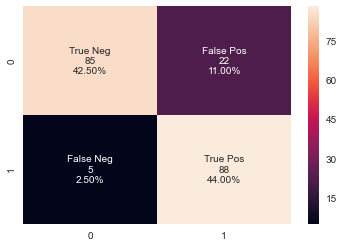

In [313]:
cm = confusion_matrix(y,test_pred)

print("Accuracy = "+str(accuracy_score(y, test_pred)))
print("F1 SCORE = "+str(f1_score(y, test_pred)))
print("PRECISION = "+str(precision_score(y,test_pred)))
print("RECALL = "+str(recall_score(y,test_pred)))
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels,fmt="")


# Model accuracy is 86.5%
